In [1]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image
from nibabel.testing import data_path
import os
import sys
%matplotlib inline
import plotly.express as px

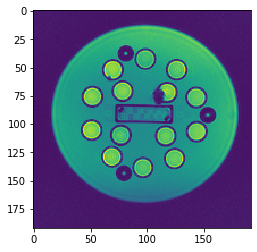

In [3]:
import pydicom
MapAngles = np.zeros([192,192,7])
MapAngles[:,:,0] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0003.0009.2020.11.19.21.00.11.258356.259817697.IMA").pixel_array
MapAngles[:,:,1] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0004.0009.2020.11.19.21.00.11.258356.259818723.IMA").pixel_array
MapAngles[:,:,2] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0005.0009.2020.11.19.21.00.11.258356.259819749.IMA").pixel_array
MapAngles[:,:,3] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0006.0009.2020.11.19.21.00.11.258356.259820775.IMA").pixel_array
MapAngles[:,:,4] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0007.0009.2020.11.19.21.00.11.258356.259821801.IMA").pixel_array
MapAngles[:,:,5] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0008.0009.2020.11.19.21.00.11.258356.259822827.IMA").pixel_array
MapAngles[:,:,6] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0009.0009.2020.11.19.21.00.11.258356.259823853.IMA").pixel_array

plt.imshow(MapAngles[:,:,1])

In [30]:
from scipy.optimize import leastsq
def residual(variables, x, data, M0,eps_data):
    """Model a decaying sine wave and subtract data."""
    T1 = variables[0]

    model = M0*((1-np.exp(-15/T1))/(1-np.cos(np.deg2rad(x))*np.exp(-15/T1)))*np.sin(np.deg2rad(x))

    return (data-model) / eps_data

In [31]:
def T1_non_lin(MapAngles, angles, TF, T1_estim):
    eps_data =1
    variables = [1000]
    T1graph = np.ones([MapAngles.shape[0], MapAngles.shape[1]])
    for i in range(0, MapAngles.shape[0]):  
        for j in range(0,MapAngles.shape[1]):
            coordx=i
            coordy=j
            Magnt = MapAngles[coordx, coordy, :]
            T1 = leastsq(residual, variables, args=(angles, Magnt, 5000, eps_data))[0] #M0 estimé à partir des valeurs du signal par rapport à celles simulées avec M0 = 1
            if(T1<3000 and T1>-3000): 
                T1graph[coordx][coordy] = T1
    return T1graph

In [32]:
def T1_lin(Map1, Map2, angles, TF): #B1?
    T1graph = np.zeros(Map1.shape)
    for i in range(0,Map1.shape[0]):
        for j in range(0,Map1.shape[1]):
            coordx=i
            coordy=j
            pente = ((Map2[coordx][coordy]/np.sin(np.deg2rad(angles[1])))-(Map1[coordx][coordy]/np.sin(np.deg2rad(angles[0]))))/((Map2[coordx][coordy]/np.tan(np.deg2rad(angles[1])))-(Map1[coordx][coordy]/np.tan(np.deg2rad(angles[0]))))
            if (pente > 0):
                T1 = -TF/(np.log(pente))
                if (T1 < 3000) and (T1 >= -3000):
                    T1graph[coordx][coordy] = T1
    return T1graph

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide



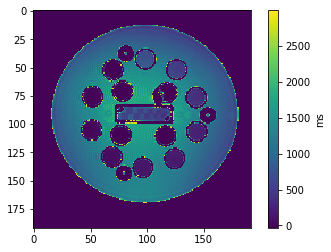

1467.8847173299605


In [33]:
angles = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
T1graph = T1_non_lin(MapAngles, angles, 15, 1000)
plt.imshow(T1graph, interpolation='nearest')
cb = plt.colorbar()
cb.set_label('ms')
plt.show()
print(T1graph[60][60])

In [26]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

all_options = {
    '3 deg': [],
    '5 deg': [],
    '10 deg': [],
    '15 deg': [],
    '20 deg': [],
    '25 deg': [],
    '30 deg': [],
    'T1 lin':[],
    'T1 non_lin':[]
}
app.layout = html.Div([
    dcc.RadioItems(
        id='countries-radio',
        options=[{'label': k, 'value': k} for k in all_options.keys()],
        value='America'
    ),

    html.Hr(),

    dcc.RadioItems(id='cities-radio'),

    html.Hr(),

    html.Div(id='display-selected-values'),
    dcc.Graph(
        id='example-graph',
        figure=px.imshow(MapAngles[:,:,1])
    )
])


@app.callback(
    Output('example-graph', 'figure'),
    Input('countries-radio', 'value'))
def update_figure(selected_country):
    #filtered_df = df[df.year == selected_year]
    if (selected_country == '3 deg'):
        fig = px.imshow(MapAngles[:,:,0])
    if (selected_country == '5 deg'):
        fig = px.imshow(MapAngles[:,:,1])  
    if (selected_country == '10 deg'):
        fig = px.imshow(MapAngles[:,:,2])
    if (selected_country == '15 deg'):
        fig = px.imshow(MapAngles[:,:,3])
    if (selected_country == '20 deg'):
        fig = px.imshow(MapAngles[:,:,4])
    if (selected_country == '25 deg'):
        fig = px.imshow(MapAngles[:,:,5])
    if (selected_country == '30 deg'):
        fig = px.imshow(MapAngles[:,:,6])
    if (selected_country == 'T1 non_lin'):
        angles = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
        T1graph = T1_non_lin(MapAngles, angles, 15, 1000)
        fig = px.imshow(T1graph)
    if (selected_country == 'T1 lin'):
        angles = np.array([3.0,30.0])
        T1graph = T1_lin(MapAngles[:,:,0],MapAngles[:,:,6], angles, 15)
        fig = px.imshow(T1graph)        
    return fig


if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/


C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide



[1713.78248298]


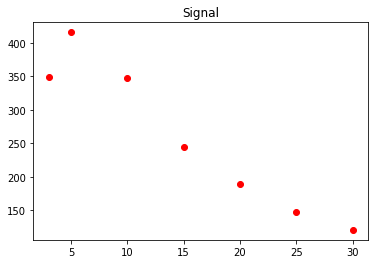

In [25]:
TF=15
xdata = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
ydata = MapAngles[100, 100, :]
plt.title('Signal')
plt.scatter(xdata, ydata,c='r')
eps_data =1
variables = [1000]
out = leastsq(residual, variables, args=(xdata, ydata, eps_data))[0]
print(out)